# CTD χpod A05 section

1. [x] read chipod mat file
1. [x] read CTD nc file
1. [x] bin-average CTD data appropriately
1. [ ] convert datetime properly
1. [x] run for NATRE region (only 10 profiles!)
1. [ ] Plot spiciness to decide how to cut up section into segments
1. [ ] write function to process segments
1. [ ] calculating using KT instead of Kρ
1. [ ] make sure data is thorpesorted before attempting estimate

## Suggestions

1. Don't set lat, lon=0 when data is missing
1. lat, lon should match the CTD data exactly
1. Need cast numbers that line up with CTD file

In [1]:
%load_ext watermark
%matplotlib inline

import glob
import os

import cf_xarray as cfxr
import dcpy
import distributed
import eddydiff as ed
import flox
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import tqdm
import xarray as xr
import xgcm
from IPython.display import Image

xr.set_options(keep_attrs=True, use_flox=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200
plt.style.use("ggplot")


%watermark -iv
xr.DataArray([1.0])

matplotlib : 3.5.1
xarray     : 0.10.3+dev29.ga8e0be8d1
dcpy       : 0.1
flox       : 0.3.1.dev13+g74cc5eb.d20220104
distributed: 2021.12.0
numpy      : 1.22.0
pandas     : 1.3.5
scipy      : 1.7.3
eddydiff   : 0.1
tqdm       : 4.62.3
xgcm       : 0.6.0
cf_xarray  : 0.6.3



<xarray.DataArray (dim_0: 1)>
array([1.])
Dimensions without coordinates: dim_0

In [2]:
if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(
    n_workers=6,
    threads_per_worker=2,
    env={"MKL_NUM_THREADS": 1, "NUMBA_NUM_THREADS": 1, "OMP_NUM_THREADS": 1},
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56241,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56268,Total threads: 2
Dashboard: http://127.0.0.1:56270/status,Memory: 2.67 GiB
Nanny: tcp://127.0.0.1:56248,


In [3]:
dirname = os.path.expanduser("~/datasets/microstructure/ctd-chipod/")
chifile = f"{dirname}/A05_combined_zsm20m_fmax7Hz_respcorr0_fc_99hz_gamma20_test1.mat"
ctdfile = f"{dirname}/A05_74EQ20151206_ctd.nc"

In [4]:
from scipy.io import loadmat

mat = loadmat(chifile)
ds = xr.Dataset()

varnames = [
    "eps_f",
    "chi_f",
    "KT_f",
    "P_f",
    "cast",
    "sn_avail",
    "SN",
    "lon",
    "lat",
    "datenum",
]
attrs = {
    "eps_f": {"long_name": "$ε$", "units": "W/kg"},
    "chi_f": {"long_name": "$χ$", "units": "C^2/s"},
    "KT_f": {"long_name": "$K_T$", "units": "m^2/s"},
    "P_f": {
        "standard_name": "sea_water_pressure",
        "units": "dbar",
        "axis": "Z",
        "positive": "down",
    },
    "lon": {"standard_name": "longitude"},
    "lat": {"standard_name": "latitude"},
}

for var in varnames:
    data = mat["XPsum"][0, 0][var].squeeze()
    if data.ndim == 2:
        if var == "SN":
            dims = ("cast", "sensor")
        else:
            dims = ("P", "cast")
    elif var not in ("cast", "SN", "sn_avail", "lat", "lon", "datenum"):
        dims = ("P",)
    else:
        dims = ("cast",)
    ds[var.split("_")[0]] = (dims, data, attrs.get(var, {}))
ds = ds.rename({"sn": "num_sensors", "SN": "avail_sensors"}).set_coords(
    ["lat", "lon", "datenum", "num_sensors", "avail_sensors"]
)
# TODO
# ds["time"] = dcpy.util.mdatenum2dt64(ds.datenum)
ds = ds.cf.guess_coord_axis()
ds["P"] = ds.P.astype(float)
ds["cast"] = ("cast", np.arange(2, 145), {"cf_role": "profile_id"})
ds = ds.rename({"P": "pressure"})
a05 = ds
a05

<xarray.Dataset>
Dimensions:        (pressure: 3001, cast: 143, sensor: 2)
Coordinates:
  * pressure       (pressure) float64 0.0 2.0 4.0 ... 5.996e+03 5.998e+03 6e+03
  * cast           (cast) int64 2 3 4 5 6 7 8 9 ... 138 139 140 141 142 143 144
    num_sensors    (cast) uint8 0 0 0 0 0 0 2 2 1 2 2 ... 2 2 2 2 2 0 0 0 0 0 2
    avail_sensors  (cast, sensor) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 2013 2016
    lon            (cast) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 -13.41
    lat            (cast) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 27.91
    datenum        (cast) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 7.363e+05
Dimensions without coordinates: sensor
Data variables:
    eps            (pressure, cast) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    chi            (pressure, cast) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    KT             (pressure, cast) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan

In [5]:
ctd_raw = xr.open_dataset(ctdfile)
# line up cast numbers with CTD-χpod
ctd_raw["cast"] = ctd_raw.station.astype(int)
ctd_raw = ctd_raw.drop_vars("station").swap_dims({"N_PROF": "cast"})
ctd_raw.cast.attrs["cf_role"] = "profile_id"
ctd_raw

<xarray.Dataset>
Dimensions:             (cast: 145, N_LEVELS: 3298)
Coordinates:
    pressure            (cast, N_LEVELS) float64 ...
    latitude            (cast) float64 ...
    longitude           (cast) float64 ...
    time                (cast) datetime64[ns] ...
    expocode            (cast) object ...
  * cast                (cast) int64 1 2 3 4 5 6 7 ... 140 141 142 143 144 145
    sample              (cast, N_LEVELS) object ...
Dimensions without coordinates: N_LEVELS
Data variables:
    section_id          (cast) object ...
    btm_depth           (cast) float64 ...
    ctd_temperature     (cast, N_LEVELS) float64 ...
    ctd_temperature_qc  (cast, N_LEVELS) float32 ...
    ctd_salinity        (cast, N_LEVELS) float64 ...
    ctd_salinity_qc     (cast, N_LEVELS) float32 ...
    ctd_oxygen          (cast, N_LEVELS) float64 ...
    ctd_oxygen_qc       (cast, N_LEVELS) float32 ...
    profile_type        (cast) object ...
    geometry_container  float64 ...
Attributes:
    Conventions:               CF-1.8 CCHDO-1.0
    cchdo_software_version:    hydro 1.0.1.3
    cchdo_parameters_version:  params 0.1.14
    comments:                  CTD,20160123OCPNOCBAK\n DEPTH_TYPE   : COR \n ...
    featureType:               profile

In [6]:
P = a05.cf["sea_water_pressure"].data
edges = (P[:-1] + P[1:]) / 2

grouped = ctd_raw.cf.groupby_bins("sea_water_pressure", bins=edges)
ctd = grouped.mean("N_LEVELS")
index = pd.IntervalIndex(ctd.xindexes["pressure_bins"].to_pandas_index())
ctd.coords["pressure"] = ("pressure_bins", index.mid.values)
ctd = ctd.swap_dims({"pressure_bins": "pressure"})
ctd.pressure.attrs = ctd_raw.pressure.attrs
ctd.pressure.attrs["bounds"] = "pressure_bins"
ctd

/Users/dcherian/work/python/flox/flox/aggregate_flox.py:103: RuntimeWarning: invalid value encountered in true_divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


<xarray.Dataset>
Dimensions:             (pressure: 2999, cast: 145)
Coordinates:
    pressure_bins       (pressure) object (1.0, 3.0] ... (5997.0, 5999.0]
    latitude            (cast) float64 26.43 27.0 27.0 ... 27.87 27.91 27.93
    longitude           (cast) float64 -78.67 -80.0 -79.97 ... -13.41 -13.37
    time                (cast) datetime64[ns] 2015-12-09T21:48:00 ... 2016-01...
    expocode            (cast) object '74EQ20151206' ... '74EQ20151206'
  * cast                (cast) int64 1 2 3 4 5 6 7 ... 140 141 142 143 144 145
  * pressure            (pressure) float64 2.0 4.0 6.0 ... 5.996e+03 5.998e+03
Data variables:
    ctd_temperature     (pressure, cast) float64 27.0 26.9 27.14 ... nan nan nan
    ctd_temperature_qc  (pressure, cast) float32 2.0 2.0 2.0 2.0 ... nan nan nan
    ctd_salinity        (pressure, cast) float64 36.32 35.78 35.65 ... nan nan
    ctd_salinity_qc     (pressure, cast) float32 2.0 2.0 2.0 2.0 ... nan nan nan
    ctd_oxygen          (pressure, cast) float64 198.2 197.0 199.6 ... nan nan
    ctd_oxygen_qc       (pressure, cast) float32 2.0 2.0 2.0 2.0 ... nan nan nan
    section_id          (pressure, cast) object 'A05' 'A05' ... 'A05' 'A05'
    btm_depth           (pressure, cast) float64 762.0 43.0 ... 545.0 343.0
    profile_type        (pressure, cast) object 'C' 'C' 'C' 'C' ... 'C' 'C' 'C'
    geometry_container  (pressure) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:               CF-1.8 CCHDO-1.0
    cchdo_software_version:    hydro 1.0.1.3
    cchdo_parameters_version:  params 0.1.14
    comments:                  CTD,20160123OCPNOCBAK\n DEPTH_TYPE   : COR \n ...
    featureType:               profile

In [7]:
a05["temp"] = ctd.ctd_temperature
a05["salt"] = ctd.ctd_salinity
a05.coords["bottom_depth"] = ctd.btm_depth
a05["gamma_n"] = dcpy.oceans.neutral_density(a05)

/Users/dcherian/mambaforge/envs/eddydiff/lib/python3.9/site-packages/cf_xarray/accessor.py:1498: UserWarning: Variables {'ctd_salinity_qc'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/dcherian/mambaforge/envs/eddydiff/lib/python3.9/site-packages/cf_xarray/accessor.py:1498: UserWarning: Variables {'ctd_temperature_qc'} not found in object but are referred to in the CF attributes.
  warnings.warn(


In [8]:
# gappy lat, lon from Aurelie
a05 = a05.drop_vars(["lat", "lon"])

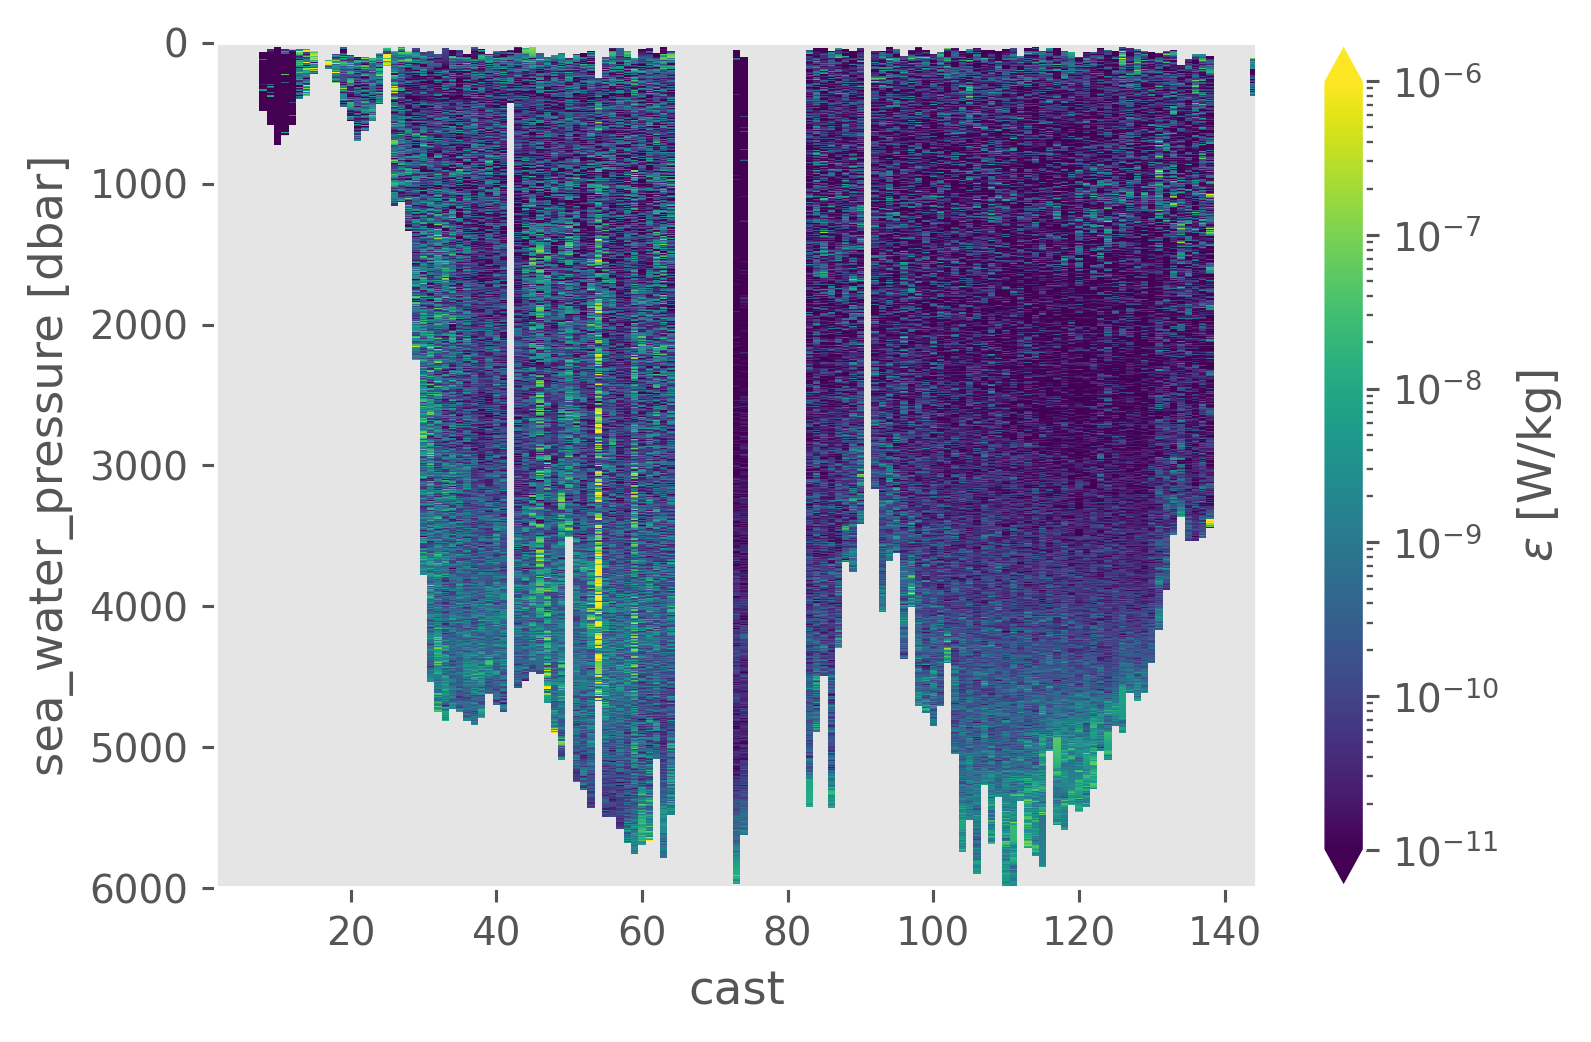

In [9]:
a05.eps.cf.plot(x="cast", y="Z", norm=mpl.colors.LogNorm(1e-11, 1e-6))

In [13]:
a05.query({"cast": "longitude < -23 & longitude > -28"})

<xarray.Dataset>
Dimensions:        (pressure: 3001, cast: 8, sensor: 2)
Coordinates:
  * pressure       (pressure) float64 0.0 2.0 4.0 ... 5.996e+03 5.998e+03 6e+03
  * cast           (cast) int64 119 120 121 122 123 124 125 126
    num_sensors    (cast) uint8 2 2 2 2 2 2 2 1
    avail_sensors  (cast, sensor) uint16 2013 2016 2013 2016 ... 2016 2013 0
    datenum        (cast) float64 7.363e+05 7.363e+05 ... 7.363e+05 7.363e+05
    pressure_bins  (pressure) object nan (1.0, 3.0] ... (5997.0, 5999.0] nan
    latitude       (cast) float64 24.5 24.5 24.5 24.5 24.5 24.5 24.5 24.5
    longitude      (cast) float64 -27.93 -27.21 -26.47 ... -24.99 -24.25 -23.5
    time           (cast) datetime64[ns] 2016-01-12T17:14:00 ... 2016-01-16T0...
    expocode       (cast) object '74EQ20151206' ... '74EQ20151206'
    bottom_depth   (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: sensor
Data variables:
    eps            (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
    chi            (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
    KT             (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
    temp           (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
    salt           (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
    gamma_n        (cast, pressure) float64 nan nan 25.73 25.73 ... nan nan nan

In [10]:
import gsw

a05["SA"] = gsw.SA_from_SP(
    a05.cf["sea_water_practical_salinity"],
    a05.cf["sea_water_pressure"],
    a05.cf["longitude"],
    a05.cf["latitude"],
)
a05.SA.attrs["standard_name"] = "sea_water_absolute_salinity"

a05["CT"] = gsw.CT_from_t(
    a05.cf["sea_water_absolute_salinity"],
    a05.cf["sea_water_temperature"],
    a05.cf["sea_water_pressure"],
)
a05.CT.attrs = {"standard_name": "sea_water_conservative_temperature", "units": "C"}
a05

<xarray.Dataset>
Dimensions:        (pressure: 3001, cast: 143, sensor: 2)
Coordinates:
  * pressure       (pressure) float64 0.0 2.0 4.0 ... 5.996e+03 5.998e+03 6e+03
  * cast           (cast) int64 2 3 4 5 6 7 8 9 ... 138 139 140 141 142 143 144
    num_sensors    (cast) uint8 0 0 0 0 0 0 2 2 1 2 2 ... 2 2 2 2 2 0 0 0 0 0 2
    avail_sensors  (cast, sensor) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 2013 2016
    datenum        (cast) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 7.363e+05
    pressure_bins  (pressure) object nan (1.0, 3.0] ... (5997.0, 5999.0] nan
    latitude       (cast) float64 27.0 27.0 27.0 27.01 ... 27.79 27.87 27.91
    longitude      (cast) float64 -80.0 -79.97 -79.94 ... -13.78 -13.55 -13.41
    time           (cast) datetime64[ns] 2015-12-10T06:54:00 ... 2016-01-20T2...
    expocode       (cast) object '74EQ20151206' ... '74EQ20151206'
    bottom_depth   (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: sensor
Data variables:
    eps            (pressure, cast) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    chi            (pressure, cast) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    KT             (pressure, cast) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    temp           (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
    salt           (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
    gamma_n        (cast, pressure) float64 nan 23.33 23.32 ... nan nan nan
    SA             (pressure, cast) float64 nan nan nan nan ... nan nan nan nan
    CT             (pressure, cast) float64 nan nan nan nan ... nan nan nan nan

In [11]:
a05["τ1"] = gsw.spiciness1(a05.SA, a05.CT)
a05.τ1.attrs=  {"standard_name": "spiciness", "long_name": "$τ_1$"}

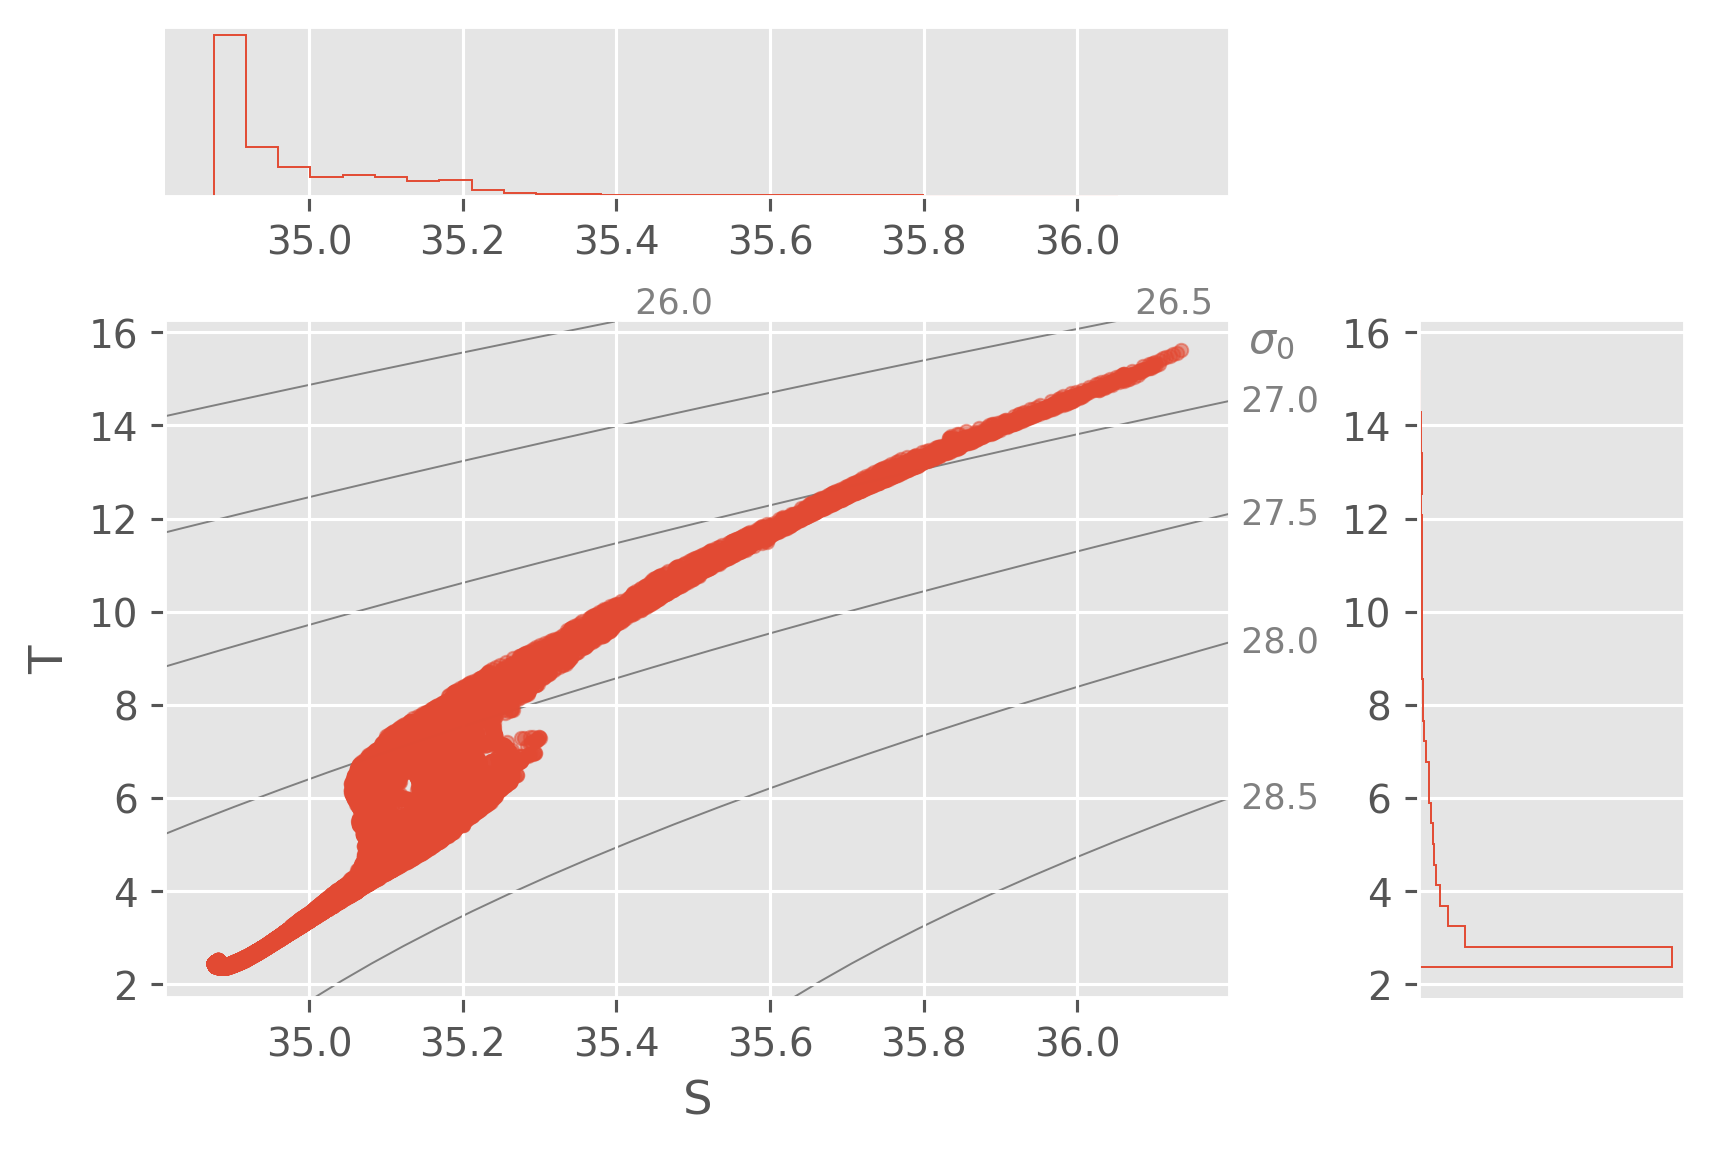

In [12]:
subset = a05.cf.sel(Z=slice(400, None)).isel(cast=slice(100, 120))
dcpy.oceans.TSplot(subset.salt, subset.temp, hexbin=False);

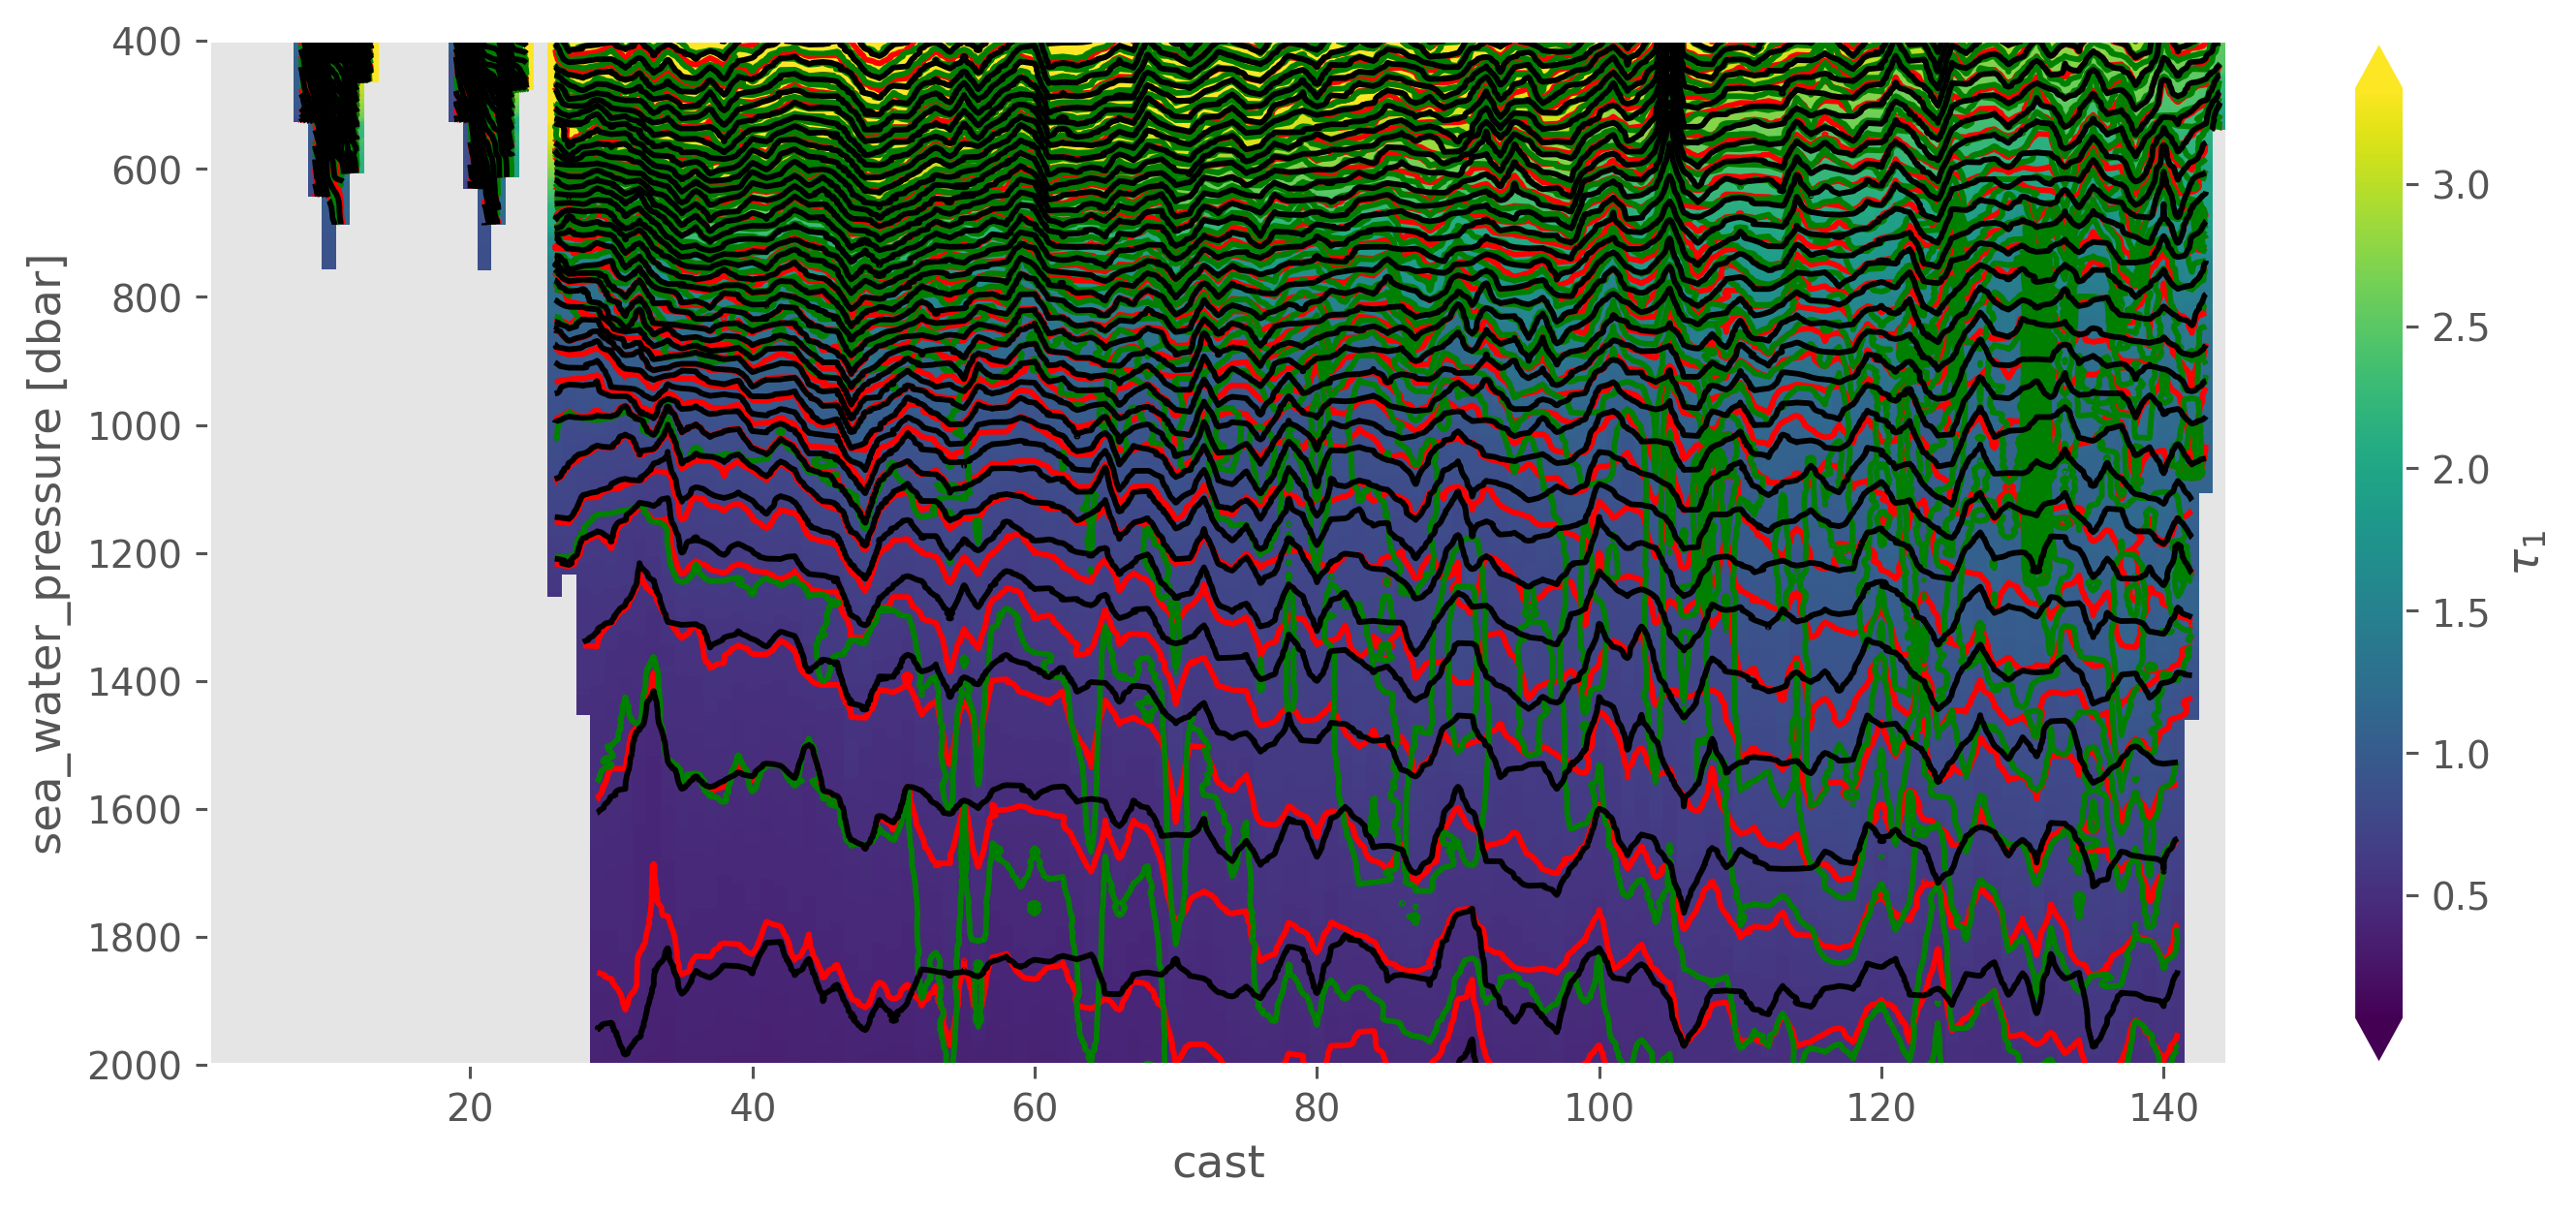

In [13]:
subset = a05.cf.sel(Z=slice(400, None))

plt.figure()
subset.τ1.reset_coords(drop=True).cf.plot(robust=True)
subset.CT.reset_coords(drop=True).cf.plot.contour(colors="r", levels=51)
subset.SA.reset_coords(drop=True).cf.plot.contour(colors="g", levels=51)
subset.gamma_n.reset_coords(drop=True).cf.plot.contour(colors="k", levels=51)
plt.ylim(2000, 400)
plt.gcf().set_size_inches((12,5))

In [14]:
subset.cf

Coordinates:
- CF Axes:   X: ['longitude']
             Y: ['latitude']
           * Z: ['pressure']
             T: ['time']

- CF Coordinates:   longitude: ['longitude']
                    latitude: ['latitude']
                  * vertical: ['pressure']
                    time: ['time']

- Cell Measures:   area, volume: n/a

- Standard Names:   latitude: ['latitude']
                    longitude: ['longitude']
                    sea_floor_depth_below_sea_surface: ['bottom_depth']
                  * sea_water_pressure: ['pressure']
                    time: ['time']

- Bounds:   Z: ['pressure_bins']
            pressure: ['pressure_bins']
            sea_water_pressure: ['pressure_bins']
            vertical: ['pressure_bins']

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   neutral_density: ['gamma_n']
                    sea_water_absolute_salinity: ['SA']
                    sea_water_conservative_temperature: ['CT']
                    sea_water_pra

In [15]:
subset = a05.isel(cast=slice(100, 130))
subset = subset.where(subset.chi > 0)
subset = ed.sections.add_ancillary_variables(subset)
subset = dcpy.oceans.thorpesort(subset, by="gamma_n", core_dim="pressure")
bins = ed.sections.choose_bins(
    a05.cf["neutral_density"], depth_range=np.arange(150, 3150, 100), decimals=3
)

/Users/dcherian/mambaforge/envs/eddydiff/lib/python3.9/site-packages/cf_xarray/accessor.py:1498: UserWarning: Variables {'ctd_salinity_qc'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/Users/dcherian/mambaforge/envs/eddydiff/lib/python3.9/site-packages/cf_xarray/accessor.py:1498: UserWarning: Variables {'ctd_temperature_qc'} not found in object but are referred to in the CF attributes.
  warnings.warn(
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/dcherian/mambaforge/envs/eddydiff/lib/python3.9/site-packages/cf_xarray/accessor.py:1498: UserWarning: Variables {'ctd_salinity_qc'} not found in object but are referred to in the CF attributes.
  warnings.warn(


In [22]:
subset.latitude

<xarray.DataArray 'latitude' (cast: 30)>
array([24.50221, 24.49918, 24.50153, 24.49959, 24.49994, 24.50236,
       24.4997 , 24.50004, 24.50173, 24.5003 , 24.50082, 24.50056,
       24.5002 , 24.49885, 24.50024, 24.50004, 24.50011, 24.49965,
       24.50282, 24.50033, 24.50074, 24.49851, 24.49976, 24.49831,
       24.4998 , 24.70819, 24.91691, 25.12609, 25.33439, 25.54257])
Coordinates:
  * cast                (cast) int64 102 103 104 105 106 ... 127 128 129 130 131
    num_sensors         (cast) uint8 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 1 1 2 2 2 2
    datenum             (cast) float64 7.363e+05 7.363e+05 ... 7.363e+05
    latitude            (cast) float64 24.5 24.5 24.5 24.5 ... 25.13 25.33 25.54
    longitude           (cast) float64 -38.7 -38.07 -37.43 ... -21.03 -20.42
    time                (cast) datetime64[ns] 2016-01-07T08:59:00 ... 2016-01...
    expocode            (cast) object '74EQ20151206' ... '74EQ20151206'
    reference_pressure  int64 0
Attributes:
    whp_name:         LATITUDE
    standard_name:    latitude
    units:            degree_north
    C_format:         %9.4f
    source_C_format:  %.5f
    axis:             Y

In [16]:
avg = ed.sections.bin_average_vertical(subset, "neutral_density", bins=bins)

/Users/dcherian/mambaforge/envs/eddydiff/lib/python3.9/site-packages/cf_xarray/accessor.py:1498: UserWarning: Variables {'ctd_salinity_qc'} not found in object but are referred to in the CF attributes.
  warnings.warn(


In [17]:
avg.load(scheduler=client)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<xarray.Dataset>
Dimensions:             (gamma_n: 29, bound: 2)
Coordinates:
  * gamma_n             (gamma_n) float64 26.14 26.56 26.76 ... 28.07 28.07
  * bound               (bound) <U5 'lower' 'upper'
    num_obs             (gamma_n) int64 1056 1560 1264 1442 ... 1731 1302 1512
    pres                (gamma_n) float64 137.5 213.6 ... 2.891e+03 2.984e+03
    reference_pressure  int64 0
    gamma_n_bounds      (bound, gamma_n) float64 25.83 26.45 ... 28.07 28.07
Data variables: (12/36)
    chi                 (gamma_n) float64 1.536e-08 8.136e-09 ... 1.68e-11
    eps                 (gamma_n) float64 2.836e-09 1.29e-09 ... 5.492e-11
    KtTz                (gamma_n) float64 2.893e-07 1.289e-07 ... 5.74e-09
    hm                  (gamma_n) float64 68.4 102.0 82.27 ... 113.4 84.8 98.8
    theta               (gamma_n) float64 19.97 17.87 16.04 ... 2.943 2.86 2.791
    salt                (gamma_n) float64 36.9 36.59 36.24 ... 34.96 34.95 34.94
    ...                  ...
    δKρTz2              (gamma_n) float64 2.523e-08 1.046e-08 ... 6.731e-12
    δKtTzTz             (gamma_n) float64 2.598e-08 5.951e-09 ... 2.413e-12
    δresidual           (gamma_n) float64 -7.208e-09 -3.555e-09 ... -2.758e-12
    δpres               (gamma_n) float64 34.2 51.0 41.13 ... 56.7 42.4 49.4
    chib2               (gamma_n) float64 7.679e-09 4.068e-09 ... 8.4e-12
    chib2_err           (gamma_n, bound) float64 2.84e-09 ... 1.134e-11
Attributes:
    commit:   eddydiff: aebd9b9f3a82e2242f4ed80f18d6863f89a89690 |  dcpy: b95...

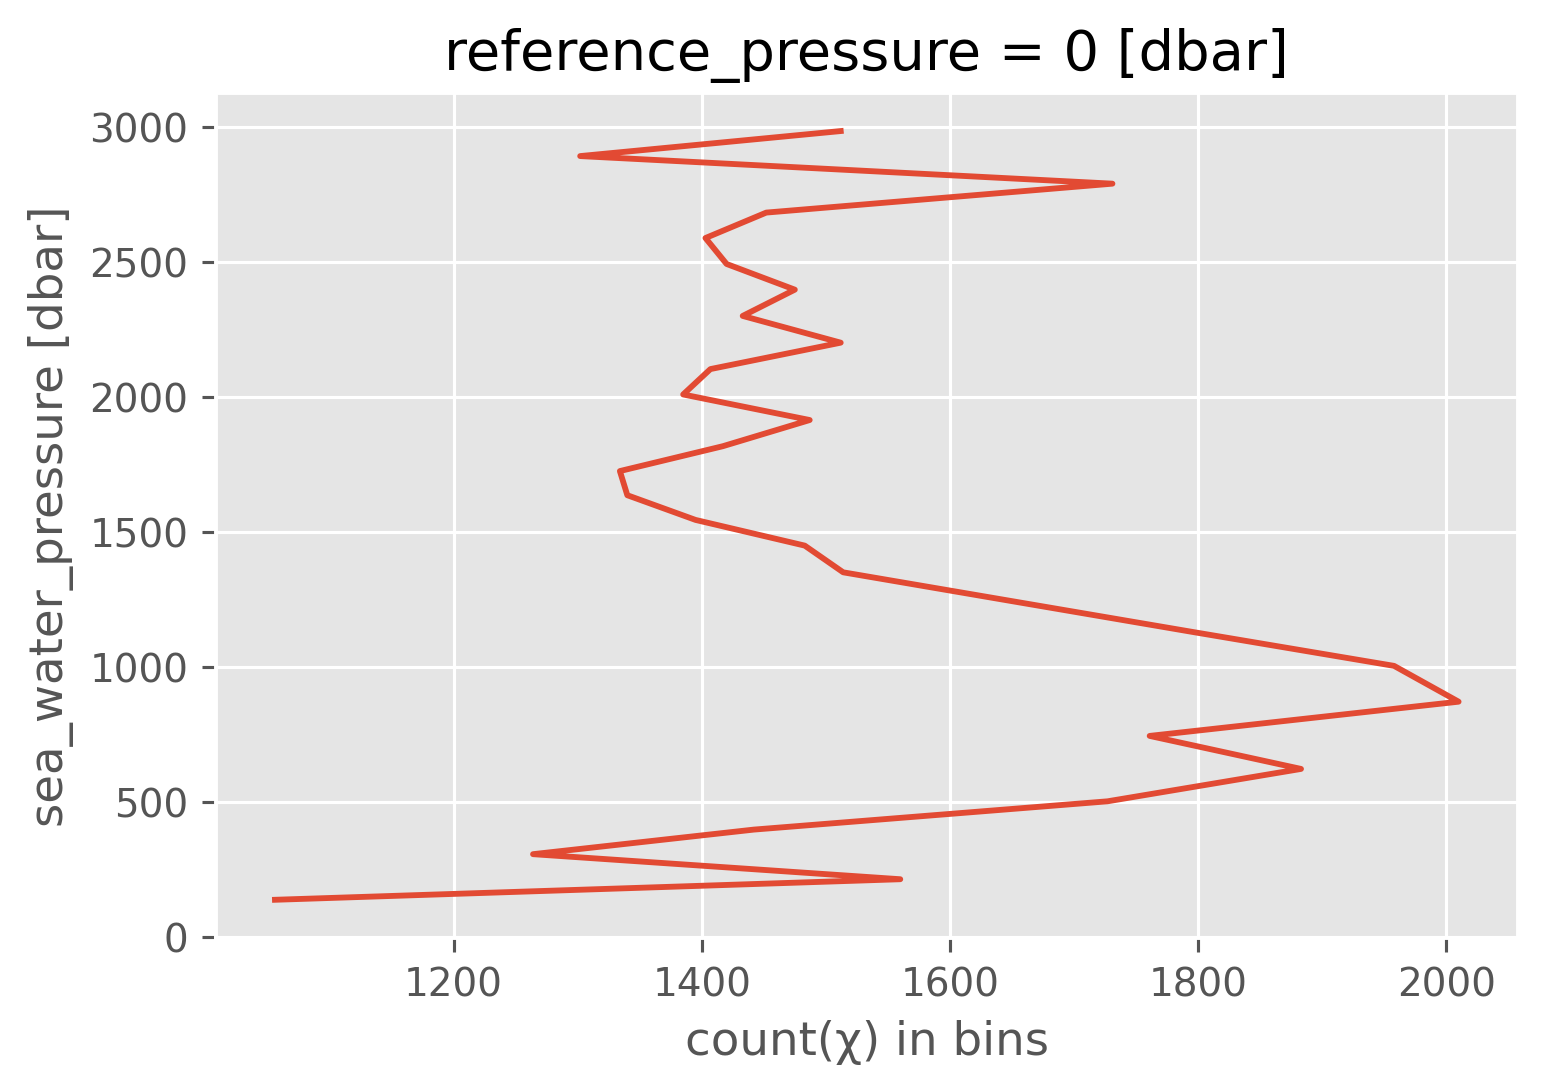

In [18]:
avg.num_obs.cf.plot(y="pres")

In [21]:
avg.to_netcdf("../datasets/ctd-A05-density-binned.nc")

## Initial exploration


### χ error bounds are big!

Order of magnitude! that's crazy

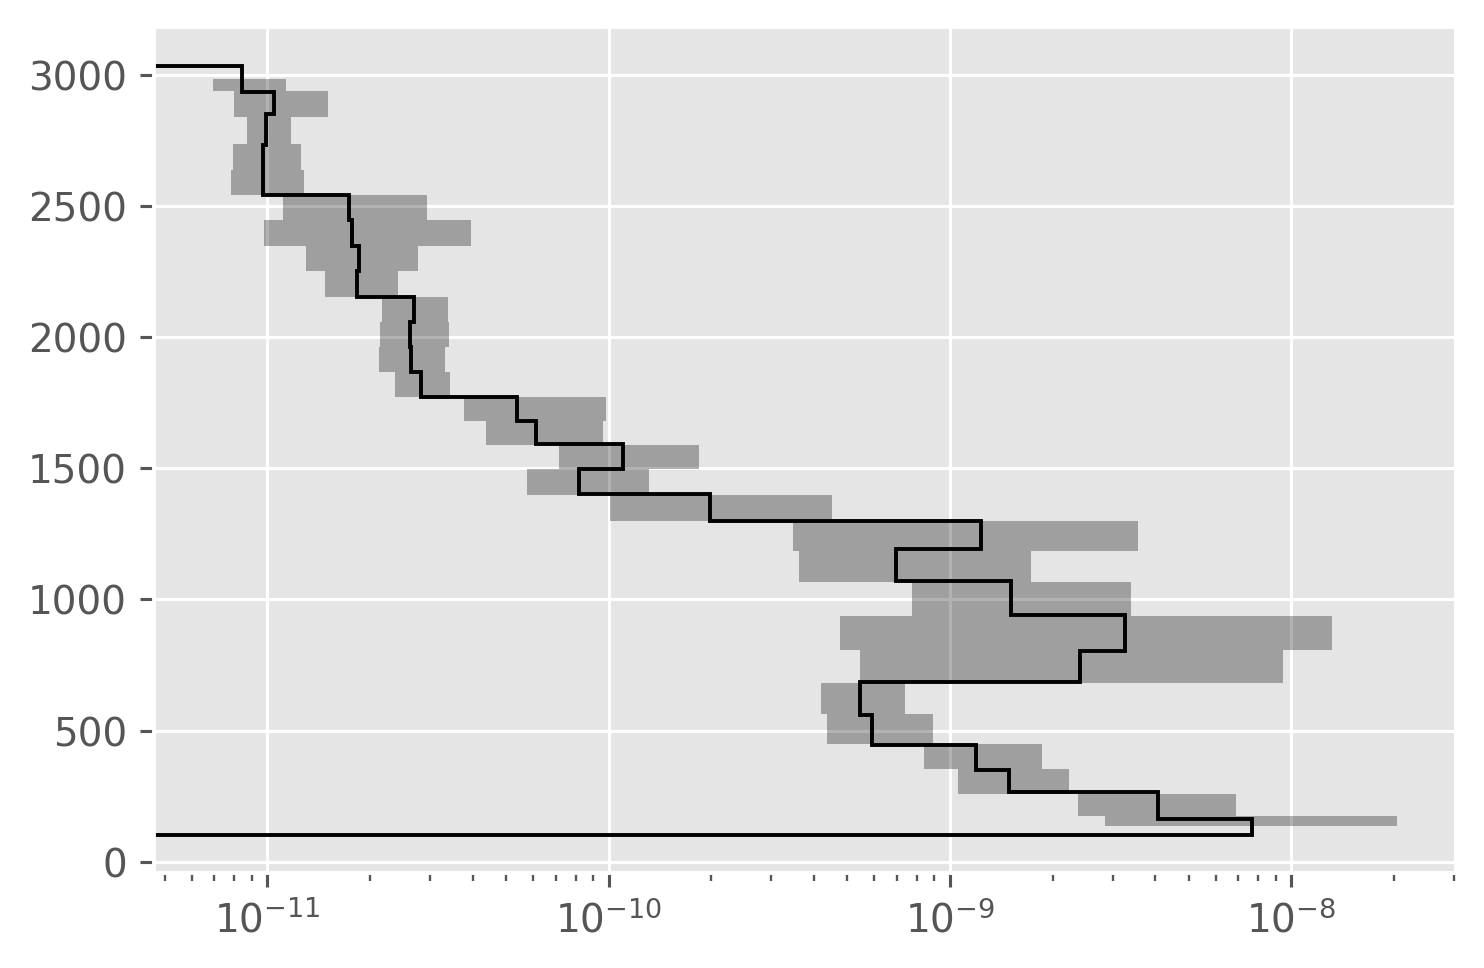

In [19]:
dcpy.plots.fill_between_bounds(avg, "chib2", y="pres", color="k")
plt.xscale("log")

### Using $K_ρ (T_z^m)^2$ 

Note this doesn't work so well. But is entirely consistent with an equivalent effort using $⟨ε_χ⟩$ estimated from the NATRE experiment.

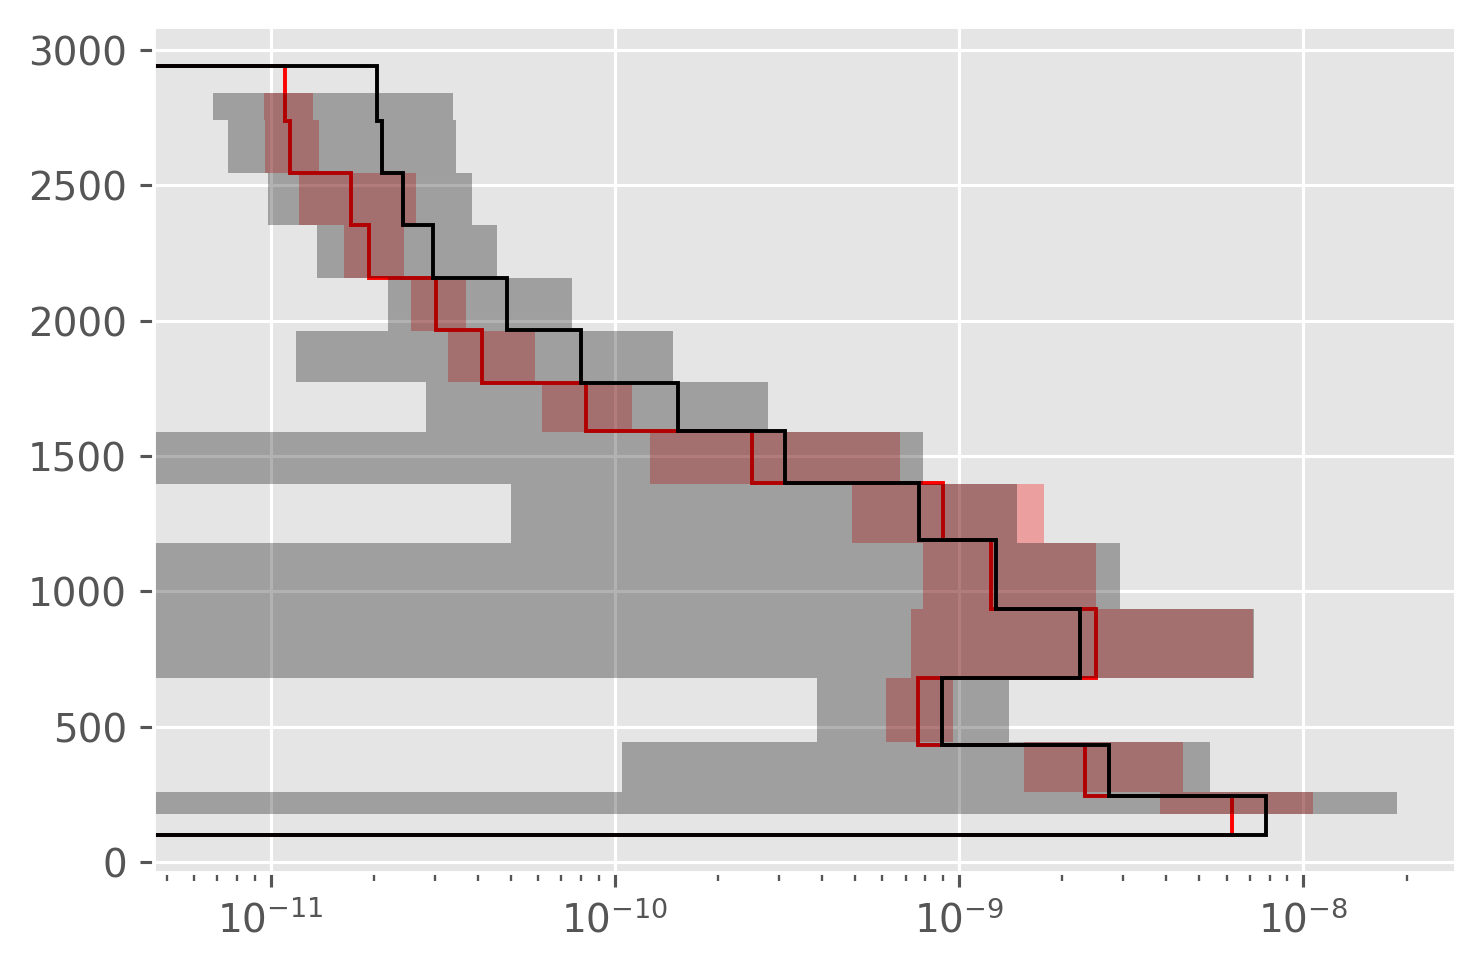

In [51]:
dcpy.plots.fill_between_bounds(avg, "chib2", y="pres", color="r")
plt.xscale("log")
dcpy.plots.fill_between_bounds(avg, "wTTz", y="pres", color="k")

### Now with $⟨K_T θ_z⟩ T_z^m$

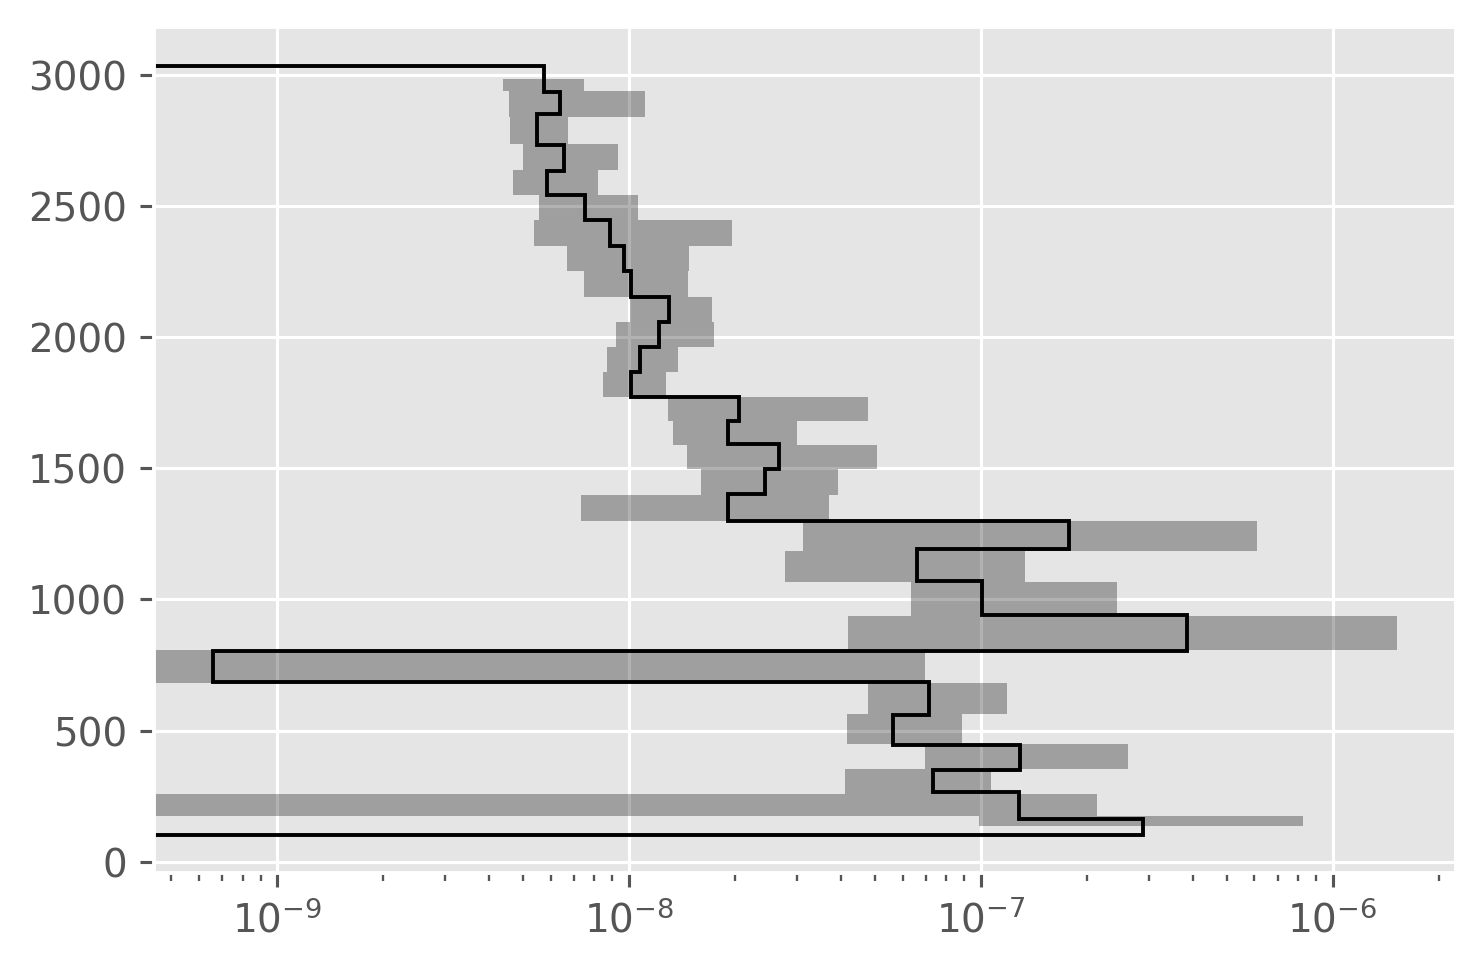

In [66]:
dcpy.plots.fill_between_bounds(avg, "KtTz", y="pres", color="k")
plt.xscale("log")

### Compare all three

Large error bars relative to  NATRE microstructure.

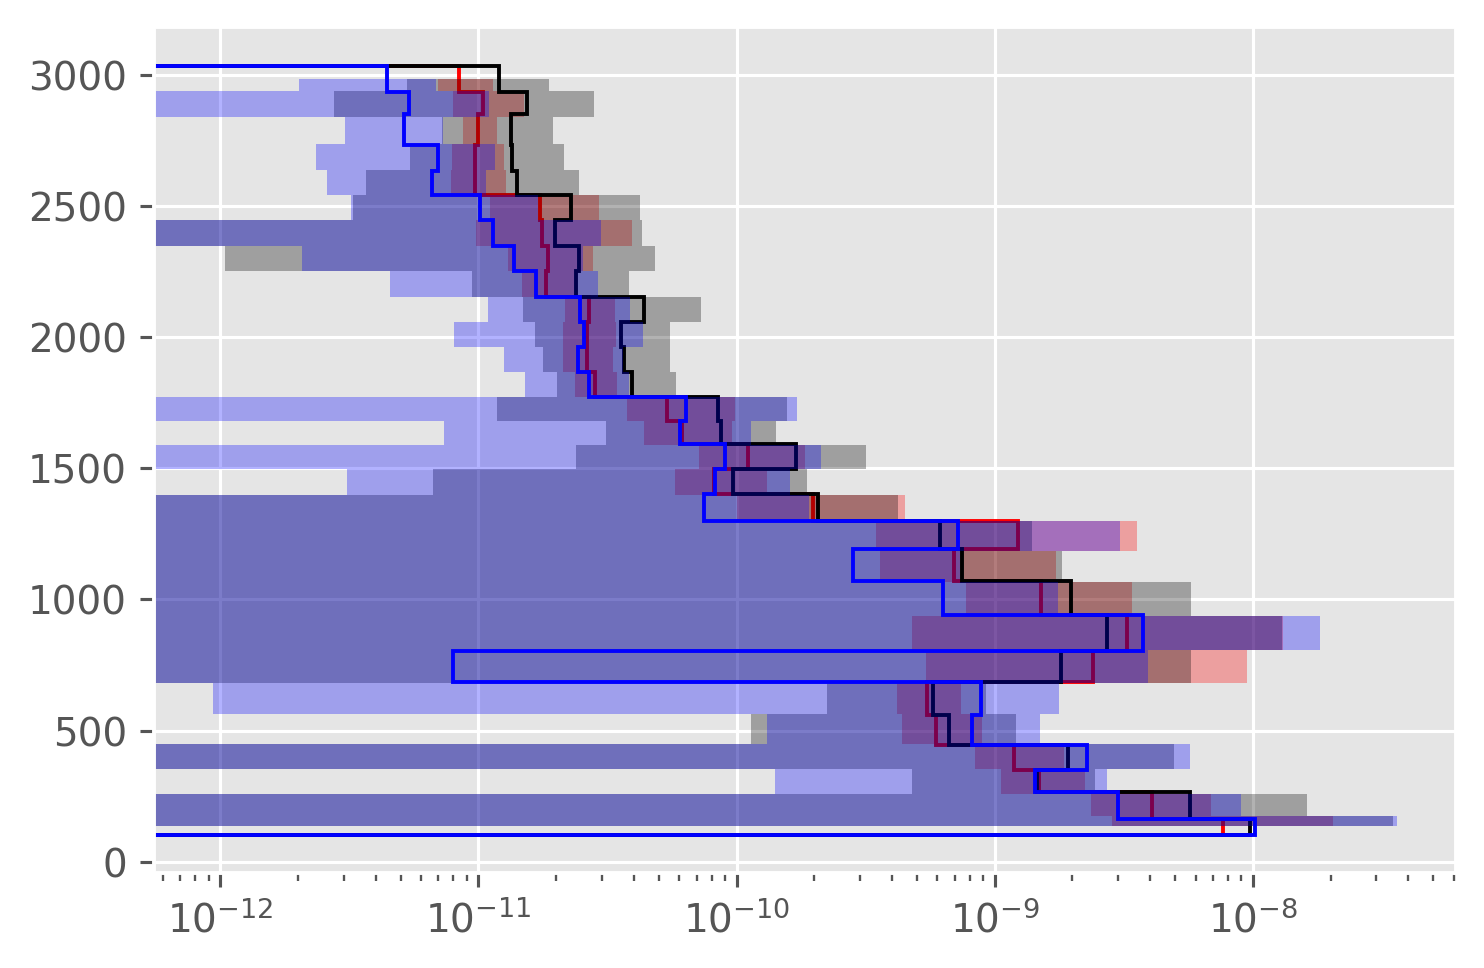

In [51]:
dcpy.plots.fill_between_bounds(avg, "chib2", y="pres", color="r")
plt.xscale("log")
dcpy.plots.fill_between_bounds(avg, "KρTz2", y="pres", color="k")
dcpy.plots.fill_between_bounds(avg, "KtTzTz", y="pres", color="b")